In [25]:
import requests
import json


url = 'localhost:5010'
entries = ['5b3ec47706f9e50f2f36acc8', '5b3fd54906f9e50f2f36acc9']
rolesa = '593f49be42d3ed97390f25a7'

#url = '10.168.20.20:5010'
#entries = ['5b491e3dd7f17a0025e48d76']
#rolesa = '5afdb8cf93beb10025c13f4f'

In [26]:
pipeline = [
    {'$match': {'_id': {'$in': entries}, 'roles._id': rolesa}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {
                    'name': 1, 'family': 1, 
                    'deps._id': 1, 'deps.endpoint': 1, 
                    'nodes._id': 1, 'nodes.deps': 1, 'nodes.name': 1, 'nodes.family': 1, 'nodes.servers': 1
                 }
    }
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()

In [27]:
import sys
import os
import numpy as np
cwd = os.getcwd()
spltted = cwd.split('/')[:-1]
sys.path.append('/'.join(spltted))

import networkx as nx
from app.services.gridOrchestrator import GridOrchestrator
from app.libs.network.baseNetwork import BaseNetwork
from app.libs.histograms.histogram import Histogram
from app.libs.histograms.grid import GridHistogram

from svgwrite import Drawing

network = BaseNetwork()
network.make(data.get('items')).get_graph()

In [28]:
class DrawArea(object):
    def __init__(self, off, size, hist, nmax):
        self._off = off
        self._size = size
        self._hist = hist
        self._nmax = nmax

    def cal_area(self, n, pointer):
        return (n * self._size[pointer]) + (n * self._off[pointer])

    def area(self):
        area_y = self.cal_area(self._nmax, 1)
        area_x = self.cal_area(max(self._hist, key=int) + 1, 0)
        return (area_x+400, area_y+100)

class DefsSVG(object):
    def __init__(self, draw):
        self.dwg = draw
        
        grid = self.dwg.symbol(id='grid')
        self.dwg.defs.add(grid)
        
        grid.viewbox(0, 0, 266.4, 154)
        grid.add(self.dwg.polyline(points=[(133.2, 0),  (0, 78.16), (133.2, 154), (266.4, 78.16)], fill="#a0501a"))
        self._base = grid


    def app(self, pos, title, size=(20, 20), unit="px"):
        opts = {
            'size': ("%s%s" % (size[0], unit), "%s%s" % (size[1], unit))
        }

        self.square(pos, (size[0], size[1]))
        
        self.add(self.dwg.use(self._base, insert=(pos[0], pos[1]+20), **opts))
        #self.add(self.dwg.text(title, insert=(pos[0]+3, pos[1] + 20), fill='black'))

    def square(self, pos, size=(60,40), unit="px"):
        opts = {
            'size': ("%s%s"%(size[0], unit), "%s%s"%(size[1], unit)),
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(255,255,0)"
        }
        
        self.add(self.dwg.rect(insert = pos, **opts))
        
    def line(self, cx, cy):
        opts = {
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(0,0,0)"
        }

        self.add(self.dwg.line(start=cx, end=cy, **opts))

    def add(self, svg):
        self.dwg.add(svg)

In [29]:
class DrawTemplateSVG(object):
    def __init__(self, hist, nmax, base, darea=DrawArea, defs=DefsSVG):
        self._off = (30, 0)
        self._size = (60, 80)

        self._hist = hist
        self._nmax = nmax

        self._area = darea(self._off, self._size, hist, nmax).area()

        self.dwg = Drawing('test.svg', size=self._area)
        self._grid_defs = defs(self.dwg)
        
        self._base = base

    def draw_app(self, pos, name, size):
        pos = self.cal_off(pos, size)
        self._grid_defs.app(pos, name, self._size)

    def draw_connect(self, pos1, pos2, w1, w2, size1, size2):
        pos1 = self.cal_pos_line(pos1, w1, self._size[0])
        pos2 = self.cal_pos_line(pos2, w2)

        self._grid_defs.line(pos1, pos2)

    def cal_off(self, pos, size):
        x = self.cal_offx(*pos, size)
        y = self.cal_offy(*pos, size)
        
        #x = (pos[0] * (pos[1]/2))
        dst = 0.3 
        
        
        size_y = self._size[1]
        size_x = self._size[0]
        y = (self._area[1]/4) - ((size_y / 2) * pos[0]) + ((size_y / 2) * pos[1])
        x = (((size_x / 2) * pos[1]) + ((size_x / 2) * pos[0]))
        
        #x *= self._size[0]

        
        return (x, y)

    def cal_offy(self, x, y, size):
        #if size > 1:
        #    off = ((size-1) * self._size[1]) + ((size-2) * self._off[1]) / 2
        
        off = self.cal_distor_y(y)
        return (y * self._off[1]) + (y * self._size[1]) + off

    def cal_distor_y(self, y):
        off = 0
        
        return off
        
    def cal_offx(self, x, y, size):
        off = self.cal_distor_x(x)
        return (x * self._off[0]) + (x * self._size[0]) + off
    
    def cal_distor_x(self, x):
        off = 0
        return off

    def cal_pos_line(self, pos, w, suff_x=0):
        apos = self.cal_off(pos, w)
        y = apos[1] + (self._size[1] / 2)
        x = apos[0] + suff_x

        return (x, y)

    def save(self):
        self.dwg.save()
        return self.dwg.get_xml()

def invert_dol(d):
    return dict((v, k) for k in d for v in d[k])

class DrawLayout(object):
    def __init__(self, grid, index, gridhist=GridHistogram, draw=DrawTemplateSVG):
        
        self._grid = grid
        self._index = index
        
        GridHistogram = gridhist(self._grid)
        self._nmax = GridHistogram.max_value()
        self._hist = GridHistogram.get_counter()
        
        self._max_x = max(self._grid, key=int)
        self._max_y = max(self._grid[0], key=int)
        
        self.drawer = draw(self._hist, self._nmax, (0, self._max_y))

    def draw_nodes(self):
        
        for col_k in range(self._max_x, 0, -1):
            if col_k in self._grid:
                columm = self._grid[col_k]
                max_y = max(self._grid[col_k], key=int)
            
                for line_k in range(0, max_y):
                    if line_k in self._grid[col_k]:
                        
                        label = self._grid[col_k][line_k]
                    
                        if label in self._index:
                            item = self._index[label]
                            name = item[3].get('name', '-')
                            size = item[2]
                        else:
                            name = '-'
                            size = 1

                        name = "%s / %s -- %s" % (col_k, line_k, size)
                        self.drawer.draw_app((col_k, line_k), name, size)
        
        return self
    
    def draw_connections(self, edges):
        for edge in edges:
            pos = []
            w = []
            size = []
            
            for i in range(2):
                ipos = self._index[edge[i]]
                pos.append(ipos)
                w.append(ipos[0])
                size.append(ipos[2])

            #self.drawer.draw_connect(*pos, *w, *size)
            
        return self
    
    def save(self):
        return self.drawer.save()

-------------------------


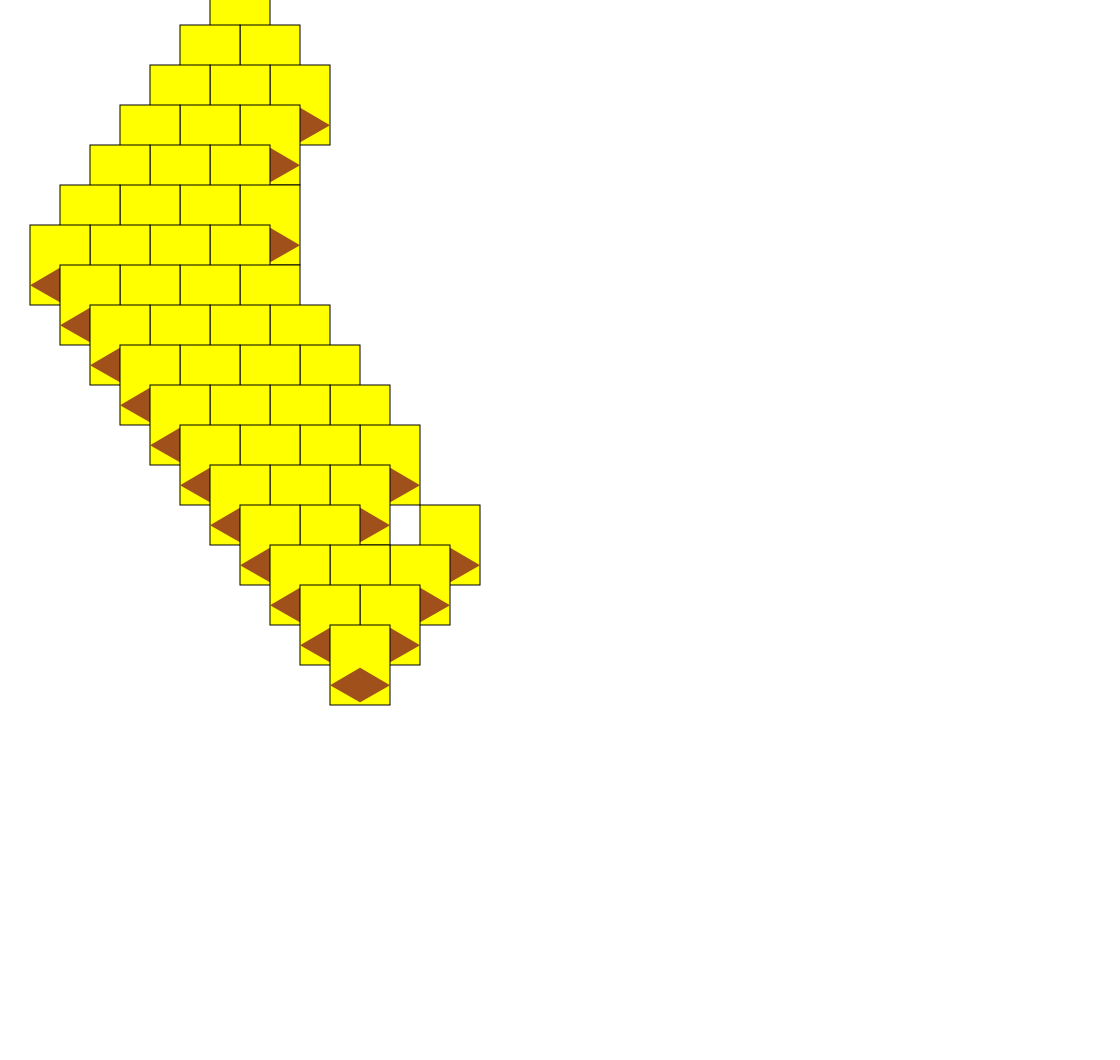

In [30]:
from IPython.display import SVG, display

print("-------------------------")
Orchestration = GridOrchestrator(network.graph)
Orchestration.create(entries)

Layout = DrawLayout(Orchestration.get_grid().get_grid(), Orchestration.get_grid().get_index())
Layout.draw_nodes()
Layout.draw_connections(network.graph.edges(data='endpoint'))
Layout.save()
   
display(SVG(filename='test.svg'))